# Simulation Benchmarks for FMI.jl
by Tobias Thummerer

Last update: 19.09.2023

🚧 This benchmark is under development, so do not give too much weight to the current results. 🚧

The purpose of this benchmark is to keep track of changes, that influence the simulation performance over different releases. Idealy, simulation time and memory usage should decrease with every new release, but new features and corrections could lead to slightly decreased performances.

Simulation of a vehicle longitudinal dynamics model with six states and time events triggered with 100 Hz. Additional state events, but less than time events. See solver log for details.

## License

In [1]:
# Copyright (c) 2023 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

In [2]:
# we use distributed to check out different FMI.jl versions over different processes
using Distributed 
using Plots
 
# versions to check
versions = ("0.11.0", "0.12.0", "0.12.4", "PATHC:\\Users\\thummeto\\Documents\\FMI.jl") # , "0.13.0")
numVersions = length(versions)

# one worker per version
workers = addprocs(numVersions);

In [3]:
# include benchmarking code
include(joinpath(@__DIR__, "benchmark.jl"));

In [4]:
# install a specific version of FMI.jl on every worker process 
@suppress begin
    futures = Vector{Any}(undef, numVersions);
    for i in 1:numVersions
        futures[i] = @spawnat workers[i] setupVersion(versions[i]);
    end
    fetch.(futures);
end

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [5]:
@everywhere workers using FMI, FMIZoo
@everywhere workers data = FMIZoo.VLDM(:train)
@everywhere workers fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME)
@everywhere workers using FMI.DifferentialEquations: Tsit5

@everywhere workers realBuffer = zeros(fmi2Real, 2)
@everywhere workers realVRs = vcat(fmu.modelDescription.stateValueReferences, fmu.modelDescription.derivativeValueReferences)

@everywhere workers x0=zeros(fmi2Real, 6)
@everywhere workers grad = (p, x0, fmu, data, solver) -> ReverseDiff.gradient((_p) -> loss(_p, x0, fmu, data, solver), p)

      From worker 3:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for RecursiveArrayToolsTrackerExt [201bfbae-74a9-54d9-992e-8e72788965ed]
      From worker 3:	│   exception = Invalid input in module list: expected NNlib.
      From worker 3:	└ @ Base loading.jl:1818


      From worker 3:	┌ Error: Error during loading of extension RecursiveArrayToolsTrackerExt of RecursiveArrayTools, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1825
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 3:	│        @ Base .\loading.jl:1255
      From worker 3:	│      [5] run_extension_callbacks(pkgid::Base.P


      From worker 3:	│        @ Base .\client.jl:522
      From worker 3:	└ @ Base loading.jl:1261
      From worker 4:	┌ Error: Error during loading of extension RecursiveArrayToolsTrackerExt of RecursiveArrayTools, use `Base.retry_load_extensions()` to retry.
      From worker 4:	│   exception =
      From worker 4:	│    1-element ExceptionStack:


      From worker 4:	│    SystemError: opening file "C:\\Users\\thummeto\\.julia\\compiled\\v1.9\\RecursiveArrayToolsTrackerExt\\jl_EC02.tmp": No such file or directory
      From worker 4:	│    Stacktrace:
      From worker 4:	│      [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
      From worker 4:	│        @ Base .\error.jl:176
      From worker 4:	│      [2] #systemerror#82
      From worker 4:	│        @ .\error.jl:175 [inlined]
      From worker 4:	│      [3] systemerror
      From worker 4:	│        @ .\error.jl:175 [inlined]
      From worker 4:	│      [4] open(fname::String; lock::Bool, read::Bool, write::Bool, create::Nothing, truncate::Nothing, append::Nothing)
      From worker 4:	│        @ Base .\iostream.jl:293
      From worker 4:	│      [5] open
      From worker 4:	│        @ .\iostream.jl:275 [inlined]
      From worker 4:	│      [6] open(fname::String, mode::String; lock::Bool)
      From worker 4:	│        @ Base .\iostream.jl:356
      From worker 4


      From worker 4:	│        @ Base .\loading.jl:2049
      From worker 4:	│     [24] top-level scope
      From worker 4:	│        @ stdin:3
      From worker 4:	│     [25] eval
      From worker 4:	│        @ .\boot.jl:370 [inlined]
      From worker 4:	│     [26] include_string(mapexpr::typeof(identity), mod::Module, code::String, filename::String)
      From worker 4:	│        @ Base .\loading.jl:1903
      From worker 4:	│     [27] include_string
      From worker 4:	│        @ .\loading.jl:1913 [inlined]
      From worker 4:	│     [28] exec_options(opts::Base.JLOptions)
      From worker 4:	│        @ Base .\client.jl:305
      From worker 4:	│     [29] _start()
      From worker 4:	│        @ Base .\client.jl:522
      From worker 4:	└ @ Base loading.jl:1261


      From worker 4:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SciMLSensitivity [1ed8b502-d754-442c-8d5d-10ac956f44a1]
      From worker 4:	│   exception = Invalid input in module list: expected DiffEqBaseZygoteExt.
      From worker 4:	└ @ Base loading.jl:1818


In [6]:
# check the installed versions per process
for w in workers 
    @info "Worker #$(w)"
    sleep(1.0)
    f = @spawnat w Pkg.status("FMI")
    fetch(f) # Pkg.status is non-blocking, so we need to sleep...
    sleep(2.0)
end

┌ Info: Worker #2
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 2:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.11.0_Benchmark\Project.toml`
      From worker 2:	⌃ [14a09403] FMI v0.11.0
      From worker 2:	Info Packages marked with ⌃ have new versions available and may be upgradable.


┌ Info: Worker #3
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 3:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.12.0_Benchmark\Project.toml`
      From worker 3:	⌃ [14a09403] FMI v0.12.0
      From worker 3:	Info Packages marked with ⌃ have new versions available and may be upgradable.


┌ Info: Worker #4
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 4:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.12.4_Benchmark\Project.toml`
      From worker 4:	  [14a09403] FMI v0.12.4


┌ Info: Worker #5
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 5:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.13.0_Benchmark\Project.toml`
      From worker 5:	  [14a09403] FMI v0.13.0 `C:\Users\thummeto\Documents\FMI.jl`


## Benchmark 1: Explicit Solver

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: Tsit5 (tolerance=1e-4)

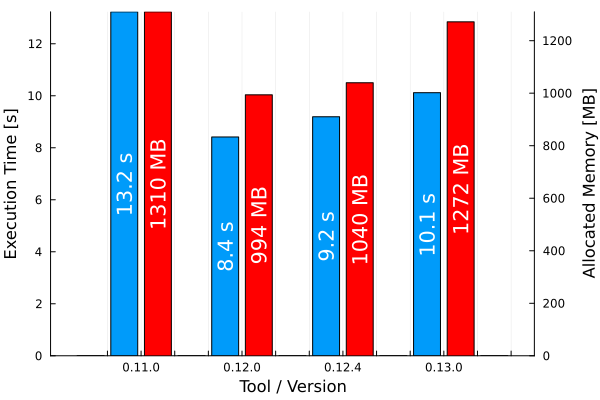

In [10]:
@everywhere workers solver=Tsit5()
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

## Benchmark 2: Automatic Solver Determination

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: auto (by DifferentialEquations.jl)

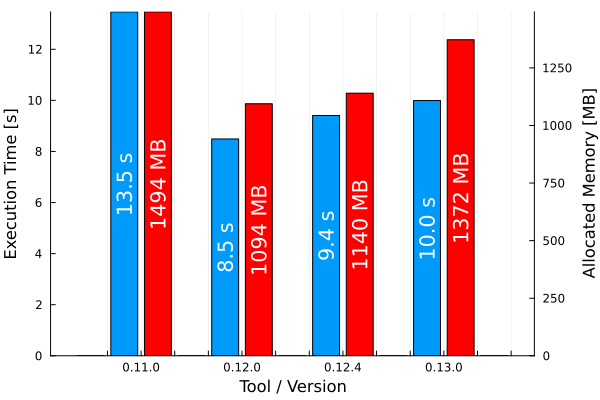

In [11]:
@everywhere workers solver=nothing
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

## Benchmark 3: Non-Julia Solver

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: CVode (tolerance=1e-4)

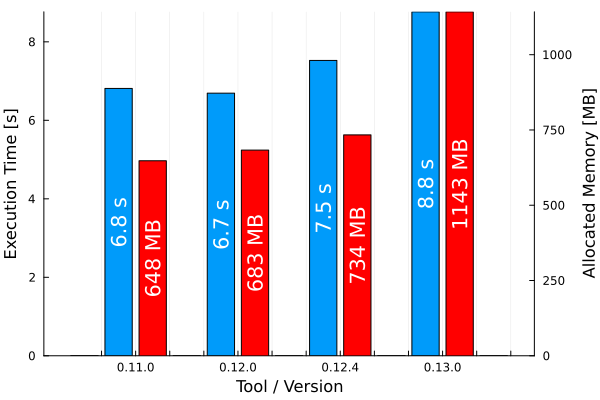

In [12]:
@everywhere workers solver = CVODE_BDF()
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

## Benchmark 4: Gradient over simulation run (Reverse-Mode AD)
First, *FMISensitivity.jl* must be loaded for *FMI.jl* >= 0.13.0.

In [10]:
# only load FMISensitivity.jl on the last worker, because there is no support in FMI.jl versions < 0.13.0
@everywhere workers[end] using FMISensitivity

      From worker 4:	WARNING: could not import FMICore.ChainRulesCore into FMISensitivity


      From worker 3:	WARNING: could not import FMICore.ChainRulesCore into FMISensitivity


      From worker 4:	ERROR: LoadError: UndefVarError: `ChainRulesCore` not defined
      From worker 4:	Stacktrace:
      From worker 4:	 [1] include
      From worker 4:	   @ .\Base.jl:457 [inlined]
      From worker 4:	 [2] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)


      From worker 4:	   @ Base .\loading.jl:2049
      From worker 4:	 [3] top-level scope
      From worker 4:	   @ stdin:3
      From worker 4:	in expression starting at C:\Users\thummeto\Documents\FMISensitivity.jl\src\FMISensitivity.jl:6
      From worker 4:	in expression starting at stdin:3


      From worker 3:	ERROR: LoadError: UndefVarError: `ChainRulesCore` not defined
      From worker 3:	Stacktrace:
      From worker 3:	 [1] include
      From worker 3:	   @ .\Base.jl:457 [inlined]


      From worker 3:	 [2] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
      From worker 3:	   @ Base .\loading.jl:2049
      From worker 3:	 [3] top-level scope
      From worker 3:	   @ stdin:3
      From worker 3:	in expression starting at C:\Users\thummeto\Documents\FMISensitivity.jl\src\FMISensitivity.jl:6
      From worker 3:	in expression starting at stdin:3


      From worker 2:	WARNING: could not import FMICore.ChainRulesCore into FMISensitivity


      From worker 2:	ERROR: LoadError: UndefVarError: `ChainRulesCore` not defined
      From worker 2:	Stacktrace:
      From worker 2:	 [1] include
      From worker 2:	   @ .\Base.jl:457 [inlined]
      From worker 2:	 [2] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
      From worker 2:	   @ Base .\loading.jl:2049
      From worker 2:	 [3] top-level scope
      From worker 2:	   @ stdin:3
      From worker 2:	in expression starting at C:\Users\thummeto\Documents\FMISensitivity.jl\src\FMISensitivity.jl:6
      From worker 2:	in expression starting at stdin:3


┌ Error: Error during package callback
│   exception = 1-element ExceptionStack:
On worker 2:
Failed to precompile FMISensitivity [3e748fe5-cd7f-4615-8419-3159287187d2] to "C:\\Users\\thummeto\\.julia\\compiled\\v1.9\\FMISensitivity\\jl_D9AE.tmp".
Stacktrace:
  [1] error
    @ .\error.jl:35
  [2] compilecache
    @ .\loading.jl:2300
  [3] compilecache
    @ .\loading.jl:2167 [inlined]
  [4] _require
    @ .\loading.jl:1805
  [5] _require_prelocked
    @ .\loading.jl:1660
  [6] _require_prelocked
    @ .\loading.jl:1658 [inlined]
  [7] macro expansion
    @ .\lock.jl:267 [inlined]
  [8] require
    @ .\loading.jl:1655
  [9] #2
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\Distributed.jl:83
 [10] #invokelatest#2
    @ .\essentials.jl:819 [inlined]
 [11] invokelatest
    @ .\essentials.jl:816
 [12] #114
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:301
 [13] run_wo

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: Tsit5 (tolerance=1e-4)

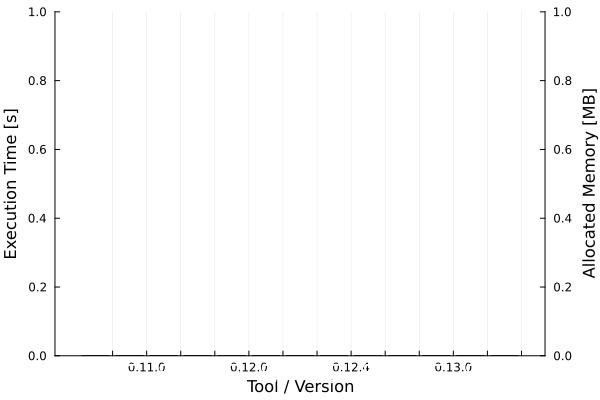

In [11]:
@everywhere workers solver = Tsit5()
@everywhere workers p=fmu.modelDescription.parameterValueReferences
@everywhere workers b=benchmarkGradient(p, x0, fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

In [68]:
# clean up
interrupt();